# The Perfect Diet for battling COVID-19

We have taken a dataset from Kaggle, consisting of the average, regular diet of the citizens of every country, along with the obesity rates, undernourishment rates, confirmed cases, deaths, and recoveries due to COVID-19 in the country at hand. 

Importing pandas to work with data :

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Importing our csv file, and then printing the first 5 rows in order to check whether the file has been imported correctly :

In [ ]:
#from google.colab import drive
#drive.mount('/drive')

data = pd.read_csv('/content/data.csv')
# To display the top 5 rows
data.head(5)

Country  ...  Unit (all except Population)
0          Afghanistan  ...                             %
1              Albania  ...                             %
2              Algeria  ...                             %
3               Angola  ...                             %
4  Antigua and Barbuda  ...                             %

[5 rows x 32 columns]

As we can see, the average diet of a specific country is given in terms of proportions of different foods, drinks and substances. 

On the far right, the covid related figures are also given, showcasing the rate of cases, deaths and recoveries.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       170 non-null    object 
 1   Alcoholic Beverages           170 non-null    float64
 2   Animal fats                   170 non-null    float64
 3   Animal Products               170 non-null    float64
 4   Aquatic Products, Other       170 non-null    float64
 5   Cereals - Excluding Beer      170 non-null    float64
 6   Eggs                          170 non-null    float64
 7   Fish, Seafood                 170 non-null    float64
 8   Fruits - Excluding Wine       170 non-null    float64
 9   Meat                          170 non-null    float64
 10  Milk - Excluding Butter       170 non-null    float64
 11  Miscellaneous                 170 non-null    float64
 12  Offals                        170 non-null    float64
 13  Oilcr

In [ ]:
data.describe()

Alcoholic Beverages  Animal fats  ...      Active    Population
count           170.000000   170.000000  ...  159.000000  1.700000e+02
mean              3.022971     0.221064  ...    0.075454  4.452364e+07
std               2.382243     0.278304  ...    0.120260  1.564182e+08
min               0.000000     0.001000  ...    0.000000  5.400000e+04
25%               0.895625     0.040225  ...    0.005115  2.816250e+06
50%               2.866150     0.116850  ...    0.018367  1.018150e+07
75%               4.710950     0.253900  ...    0.089671  3.271625e+07
max              15.370600     1.355900  ...    0.711111  1.402385e+09

[8 rows x 30 columns]

In [ ]:
!pip install skater

Importing the necessary dependencies :

In [ ]:
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

In [ ]:
from sklearn.model_selection import train_test_split

We are calculating the important features in the case of recoveries and deaths :

In [ ]:
index=data[data['Deaths'].isnull()].index
data.drop(index,inplace=True)
index=data[data['Recovered'].isnull()].index
data.drop(index,inplace=True)

In [ ]:
#import math
#data.replace((data['Confirmed']==math.nan)==True,0)

As we only want to calculate the foods, drinks and substances that lead to a recovery or a death, we refrain from considering other values such as obesity rate, undernourishment rate as well as factors regarding coronavirus. (Confirmed Cases, Deaths and Recoveries)

In [ ]:
features=['Alcoholic Beverages',	'Animal fats',	'Animal Products',	'Aquatic Products, Other',	'Cereals - Excluding Beer',	'Eggs'	,'Fish, Seafood',	
          'Fruits - Excluding Wine', 'Meat',	'Milk - Excluding Butter',	'Miscellaneous',	'Offals',	'Oilcrops',	'Pulses',	'Spices',	'Starchy Roots',
          'Stimulants',	'Sugar & Sweeteners', 'Sugar Crops',	
          'Treenuts',	'Vegetable Oils',	'Vegetables','Vegetal Products'
          ]
data[features] = data[features].astype(float)
data['Deaths'] = data['Deaths'].astype(float)
data['Recovered'] = data['Recovered'].astype(float)

##1. FOR PATIENTS WHO DIED

Our target variable in this case would be the death rate due to COVID-19 :

In [ ]:
X = data[features]
y = data['Deaths']
# mapping the target to a binary class 
y = y.apply(lambda x: 0 if x <= 0.008295 else 1)

# quickly check that we have a balanced target partition
y.sum() / len(y)

0.2360248447204969

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((120, 23), (41, 23))

Training the model :

In [ ]:
from xgboost import XGBClassifier, plot_importance

In [ ]:
model = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Predicting the values using the model we trained :

In [ ]:
xgb_predictions = model.predict(X_test)

In [ ]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]                            

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)

In [ ]:
# Evaluate predictions
import numpy as np
from sklearn import metrics
#evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Visualising the features (diet) which leads to death :

In [ ]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(model, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(model, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(model, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");


##LIME

In [ ]:
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)

In [ ]:
exp = LimeTabularExplainer(X_test.values, feature_names=features, discretize_continuous=True, class_names=['Less likely', 'More likely'])

In [ ]:
condition = 0
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
exp.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.7621212  0.23787881]


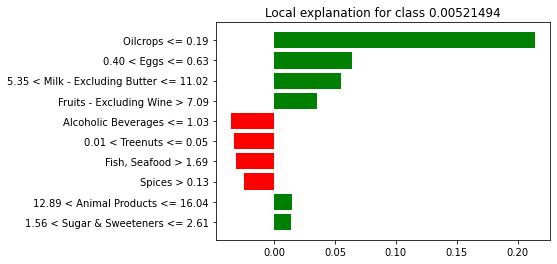

In [ ]:
explainer = LimeTabularExplainer(X_test.values, feature_names=features, class_names=data['Deaths'])
condition = 0                                                                                                                                    
exp = explainer.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba)
exp.as_pyplot_figure()                                                          

Features in the green have positive correlations with the target. Negative correlations are shown in red.

In [ ]:
condition=1
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
explainer.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.9429473  0.05705266]


##PERMUTATION IMPORTANCE

In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 7.9MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_new = DecisionTreeClassifier(random_state=0)
model_new = model_new.fit(X_train, y_train)

In [ ]:
#calculate the importance of features in model by shuffling
perm = PermutationImportance(model_new, random_state=0).fit(X_train, y_train)

In [ ]:
#show the weights (accuracy ± variance) for every feature
eli5.show_weights(perm, feature_names = features,top=30) 
#since len(data.feature_names)=30 we have assigned it to top to get all the features.

##PARTIAL DEPENDENCE PLOTS

In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

     |████████████████████████████████| 57.7MB 66kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=686f46b03f5eedfc8e91d7aae61f1d82cff9ece8ef9660ec9f5e3bb9ee0aaecb
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

In [ ]:
# plot the PD univariate plot
plot_pdp(model, X_train, 'Oilcrops')

In [ ]:
# plot the PD univariate plot
plot_pdp(model, X_train, 'Eggs')

In [ ]:
features_to_plot = ['Eggs','Oilcrops']
inter1  =  pdp.pdp_interact(model=model, dataset=X_train, model_features=features, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

plt.show()

##ICE PLOTS

In [ ]:
plot_pdp(model, X_train, 'Eggs', cluster_flag=True, nb_clusters=24, lines_flag=True)

##SHAP

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
#calculate shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
#display shap values
X_shap.head()

0         1         2         3   ...        19        20        21   22
0 -0.386444  0.013524  0.241165 -0.112894  ... -0.109925 -0.001203 -0.328963  0.0
1 -0.003208 -0.003739  0.149423  0.090626  ... -0.109809 -0.119657  0.929035  0.0
2 -0.165711  0.012109  0.126348 -0.043122  ... -0.112898  0.235851  0.438911  0.0
3 -0.092974  0.005612 -0.212465  0.107623  ...  0.363124  0.151310 -0.145165  0.0
4 -0.121735  0.011575  0.118892 -0.044000  ... -0.133950 -0.120034 -0.400485  0.0

[5 rows x 23 columns]

In [ ]:
print('Expected Value/base value: ', explainer.expected_value)

Expected Value/base value:  -1.4279482


In [ ]:
test_X=pd.DataFrame(X_test,columns=features)

In [ ]:
shap.dependence_plot("Eggs", shap_values, test_X)

In [ ]:
shap.summary_plot(shap_values, test_X)

In [ ]:
shap.summary_plot(shap_values, test_X, plot_type="bar", color='red')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], test_X.iloc[:1000,:])

##FOR RECOVERED PATIENTS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import drive
#drive.mount('/drive')

data = pd.read_csv('/content/data.csv')
# To display the top 5 rows
data.head(5)

Country  ...  Unit (all except Population)
0          Afghanistan  ...                             %
1              Albania  ...                             %
2              Algeria  ...                             %
3               Angola  ...                             %
4  Antigua and Barbuda  ...                             %

[5 rows x 32 columns]

In [ ]:
!pip install skater

In [ ]:
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
index=data[data['Deaths'].isnull()].index
data.drop(index,inplace=True)
index=data[data['Recovered'].isnull()].index
data.drop(index,inplace=True)

In [ ]:
X = data[features]
y = data['Recovered']
# mapping the target to a binary class 
y = y.apply(lambda x: 0 if x <= 0.047469 else 1)

# quickly check that we have a balanced target partition
y.sum() / len(y)

0.4968944099378882

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((120, 23), (41, 23))

In [ ]:
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)

In [ ]:
exp = LimeTabularExplainer(X_test.values, feature_names=features, discretize_continuous=True, class_names=['Less likely', 'More likely'])

In [ ]:
condition = 0
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
exp.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.25755662 0.7424434 ]


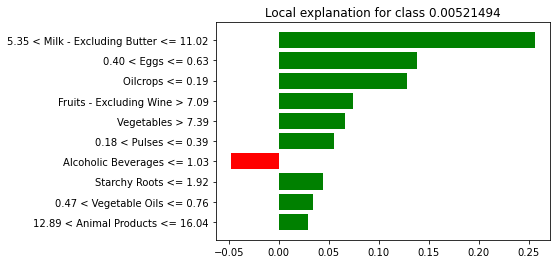

In [ ]:
explainer = LimeTabularExplainer(X_test.values, feature_names=features, class_names=data['Deaths'])
condition = 0
exp = explainer.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba)

exp.as_pyplot_figure()

In [ ]:
condition=1
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
explainer.explain_instance(X_test.iloc[condition].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.21131456 0.78868544]


In [ ]:
#calculate the importance of features in model by shuffling
perm = PermutationImportance(model, random_state=0)
perm = perm.fit(X_train, y_train)

In [ ]:
#show the weights (accuracy ± variance) for every feature
eli5.show_weights(perm, feature_names = features,top=30) 
#since len(data.feature_names)=30 we have assigned it to top to get all the features.

In [ ]:
explainer = shap.TreeExplainer(model)
#calculate shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
#display shap values
X_shap.head()

0         1         2         3   ...        19        20        21   22
0 -0.386444  0.013524  0.241165 -0.112894  ... -0.109925 -0.001203 -0.328963  0.0
1 -0.003208 -0.003739  0.149423  0.090626  ... -0.109809 -0.119657  0.929035  0.0
2 -0.165711  0.012109  0.126348 -0.043122  ... -0.112898  0.235851  0.438911  0.0
3 -0.092974  0.005612 -0.212465  0.107623  ...  0.363124  0.151310 -0.145165  0.0
4 -0.121735  0.011575  0.118892 -0.044000  ... -0.133950 -0.120034 -0.400485  0.0

[5 rows x 23 columns]

In [ ]:
print('Expected Value/base value: ', explainer.expected_value)

Expected Value/base value:  -1.4279482


In [ ]:
test_X=pd.DataFrame(X_test,columns=features)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [ ]:
shap.initjs()
shap.dependence_plot("Eggs", shap_values, test_X)

In [ ]:
shap.summary_plot(shap_values, test_X)

In [ ]:
shap.summary_plot(shap_values, test_X, plot_type="bar", color='red')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], test_X.iloc[:1000,:])

In [ ]:
features=['Obesity','Undernourished']
data[features] = data[features].astype(float)

In [ ]:
index=data[data['Obesity'].isnull()].index
data.drop(index,inplace=True)
index=data[data['Undernourished'].isnull()].index
data.drop(index,inplace=True)

In [ ]:
X = data[features]
y = data['Deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((114, 2), (39, 2))

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

NameError: ignored

In [ ]:
predictions = model.predict(X_test.values)

In [ ]:
explainer = LimeTabularExplainer(X_test.values, feature_names=features, class_names=data['Deaths'],mode='regression')
condition = 0
exp = explainer.explain_instance(X_test.iloc[condition].values, model.predict)

exp.as_pyplot_figure()

ValueError: ignored

In [ ]:
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
explainer.explain_instance(X_test.iloc[condition].values, model.predict).show_in_notebook(show_all=True)

In [ ]:
X = data[features]
y = data['Recovered']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

In [ ]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train,y_train)

NameError: ignored

In [ ]:
predictions = model.predict(X_test.values)

In [ ]:
explainer = LimeTabularExplainer(X_test.values, feature_names=features, class_names=data['Recovered'],mode='regression')
condition = 0
exp = explainer.explain_instance(X_test.iloc[condition].values, model.predict)

exp.as_pyplot_figure()

In [ ]:
print('Reference:', y_test.iloc[condition])
print('Predicted:', predictions[condition])
explainer.explain_instance(X_test.iloc[condition].values, model.predict).show_in_notebook(show_all=True)

Reference: 0.000444392
Predicted: [0.25755662 0.7424434 ]


ValueError: ignored

In [ ]:
#calculate the importance of features in model by shuffling
perm = PermutationImportance(model, random_state=0)
perm = perm.fit(X_train, y_train)

ValueError: ignored

In [ ]:
#show the weights (accuracy ± variance) for every feature
eli5.show_weights(perm, feature_names = features,top=30) 
#since len(data.feature_names)=30 we have assigned it to top to get all the features.

AttributeError: ignored